# Лабораторная работа №2
Системы с нелинейным законом управления и идентификацией параметров.

### 1. Модель системы и закон управления

$\dot P = - P^3 + dm + v(t)$

$\dot dm = -dm + G \, tanh(\omega)$


Закон управления, синтезированный по методу АКАР

$w=(-3 P^5 + 2 P^3 + 3 P^2 dm + 3 P^2 v(t) + 3 P^2 v_0 - P + Pd - dm - 2 v(t) - 2 v_0)/G$

для    $P = Pd$

### 2. Вспомогательные модули для моделирования


Базовый класс для моделирования контроллера

In [ ]:
import math
import numpy
import matplotlib.pyplot as plt 
import scipy.integrate as mdl 
import math

class PLC:
    def __init__(self, gain, step):
        self.last_t = 0.0
        self.last_call_t = 0.0
        self.last_u = 0
        self.step = step
        self.last_e = 0.0
        self.gain = gain
        self.u = []
        self.ulim = []
        self.t = []
        
    def getLimitedOutput(self,value):
        return math.tanh(value)
        
    def addOutputValue(self,time,value):
        self.t.append(time)
        self.u.append(value)
        self.ulim.append(self.getLimitedOutput(value))
        
    def output(self, x, t):
        self.addOutputValue(t, self.last_u)
        self.last_u = self.control(x, t)
        self.last_t = t
        self.addOutputValue(t,self.last_u)
        
        return self.gain*self.ulim[-1]

def calculate(func, x0, step, time, plc):
    result = {'t': [], 'u':[]}
    for i in range(0,len(x0)):
        result['x' + str(i + 1)] = []
    rstep = plc.step
    ode_step = step
    timev = numpy.linspace(0.0, time, int(time/rstep+1))
    for ti in timev:
        uk = plc.output(x0, ti)
        tk = numpy.linspace(ti, ti+rstep, int(rstep/ode_step+1))
        y = mdl.odeint(func(uk), x0, tk)
        x0 = y[-1]
        result['t'].extend(tk[:-1])
        for i in range(0,len(x0)):
            result['x' + str(i + 1)].extend(y[:-1,i])
        result['u'].extend([uk for i in tk[:-1]])
    return result


Правая часть дифференциального уравнения объекта со ступенчатым изменением параметра

In [ ]:
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                v = finish_value
            else:
                v = init_value
            return [ -math.pow(x[0],3) + x[1] + v, -x[1] + uc] 
    
        return F_internal
    return F_with_control

Вывод результатов моделирования

In [ ]:
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-') 
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--') 
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.ulim,'r-')
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')  
    plt.ylim([-2.0, 2.0])
    plt.show()

Программа моделирования

###3.  Моделирование САУ с аналитическим регулятором

In [ ]:
class AKAR(PLC):
    def __init__(self, goal, gain, dtu):
        super(AKAR,self).__init__(gain, dtu)
        self.G=gain
        self.Pd=goal
    
    def control(self, x, t):
        return (-3*math.pow(x[0],5) + 2*math.pow(x[0],3) + 3*math.pow(x[0],2)*x[1] - x[0] - x[1] + self.Pd)/self.G # возвращаем последний элемент


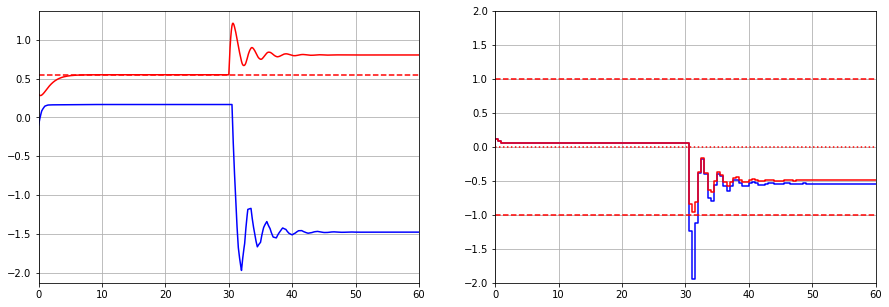

In [ ]:
v0_init = 0.0
v0_finish = 2.0
change_time = 30
goal = 0.55
gain = 3
step = 0.5
mod_step = 0.1
tk = 60
x0 = [0.3, -0.1]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

plc = AKAR(goal=goal, gain=gain, dtu=step)
res = calculate(func_ctrl, x0, mod_step, tk, plc)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=plc, goal=goal)

### 4. САУ с аналитическим регулятором и интегральной компонентой



Уравнения системы:

$\dot P = - \, P^3 + dm + v(t), \, v(t) \approx const$ , <br>
$\dot dm = -dm + G \, tanh(\omega)$ <br>
Функции макропеременных:

$\psi_1 = P - Pd$

$\psi_2 = \psi_1 + z = P - Pd + z$

$\psi_3 = dm_{internal} - dm$

Эталонные модели:

$T_1 \dot \psi_2 + \psi_2 = 0$

$T_3 \dot \psi_3 + \psi_3 = 0$

Интегральная компонента 

$\dot z = \frac 1 {T_2} \psi_1$ 

Параметр $v_0$:

$v_0 = v_{min} + \frac{(v_{max}-v_{min})}{2}$

Закон внутреннего управления $dm_{internal}$:

$dm_{internal} = P^3 - \frac P {T_2} - \frac P {T_1} + \frac Pd {T_2} + \frac Pd {T_1} - v_0 - \frac z {T_1}$

Итоговый закон управления $\omega$:

$\omega = \frac 1 {G T_1 T_2 T_3}(T_1 T_2 T_3 (-3 P^5 + 3 P^2*dm + 3 P^2*v_0 + dm) + T_1 T_2 (P^3 - dm - v_0) + T_1 T_3 (P^3 - dm - v_0) + T_1 (-P + Pd) + T_2 T_3 (P^3 - dm - v0) + T_2 (-P + Pd - z) + T_3 (-P + Pd))$

при $|\omega| < 1$.


In [ ]:
import sympy
from sympy.solvers import solve

P = sympy.symbols('P')
dm = sympy.symbols('dm')
G = sympy.symbols('G')
w = sympy.symbols('w')
z = sympy.symbols('z')
Pd = sympy.symbols('Pd')
v0 = sympy.symbols('v0')
T_1 = sympy.symbols('T_1')
T_2 = sympy.symbols('T_2')
T_3 = sympy.symbols('T_3')

dP = -P**3 + dm + v0
ddm = -dm + G * w
psi_1 = P - Pd
dz = 1/T_2*psi_1
psi_2 = psi_1 + z
dpsi_2 = sympy.diff(psi_2, P)*dP + sympy.diff(psi_2, z)*dz
dmi = solve(sympy.expand(T_1*dpsi_2 + psi_2),dm)
print(f'dz = {dz}')
print(f'dm = {str(dmi[0])}')
psi_3 = dmi[0] - dm
dpsi_3 = sympy.diff(psi_3,P)*dP + sympy.diff(psi_3,dm)*ddm + sympy.diff(psi_3,z)*dz
u = solve(sympy.expand(T_3*dpsi_3 + psi_3),w)
u_analytical = u[0]
print(f'psi_2 = {str(psi_2)}')
print(f'w = {str(u_analytical)}')

dz = (P - Pd)/T_2
dm = P**3 - P/T_2 - P/T_1 + Pd/T_2 + Pd/T_1 - v0 - z/T_1
psi_2 = P - Pd + z
w = (T_1*T_2*T_3*(-3*P**5 + 3*P**2*dm + 3*P**2*v0 + dm) + T_1*T_2*(P**3 - dm - v0) + T_1*T_3*(P**3 - dm - v0) + T_1*(-P + Pd) + T_2*T_3*(P**3 - dm - v0) + T_2*(-P + Pd - z) + T_3*(-P + Pd))/(G*T_1*T_2*T_3)


Подпрограмма для реализации нелинейного регулятора с интегральной компонентой.

In [ ]:
class AKAR_i(PLC):
    def __init__(self, goal, gain, dt, T1, T2, T3, v0):
        super(AKAR_i,self).__init__(gain, dt)
        self.dt = dt
        self.G=gain
        self.Pd=goal
        self.T1 = T1
        self.T2 = T2
        self.T3 = T3
        self.v0 = v0
        self.z = []
        self.zt = []
    
    def control(self, x, t):
        P = x[0]
        dm = x[1]
        T_1 = self.T1
        T_2 = self.T2
        T_3 = self.T3 
        Pd = self.Pd
        G = self.G
        v_0 = self.v0
        v0 = v_0
        dt = self.dt

        if len(self.z) < 1:
            z = 0.0
        else:
            z = self.z[-1] + dt/T_2*(P - Pd)
        self.z.append(z)
        self.zt.append(t)
        return (T_1*T_2*T_3*(-3*math.pow(P,5) + 3*math.pow(P,2)*dm + 3*math.pow(P,2)*v0 
                + dm) + T_1*T_2*(math.pow(P,3) - dm - v0) + T_1*T_3*(math.pow(P,3) 
                - dm - v0) + T_1*(-P + Pd) + T_2*T_3*(math.pow(P,3) - dm - v0) 
                + T_2*(-P + Pd - z) + T_3*(-P + Pd))/(G*T_1*T_2*T_3)
            


Моделирование и результаты.

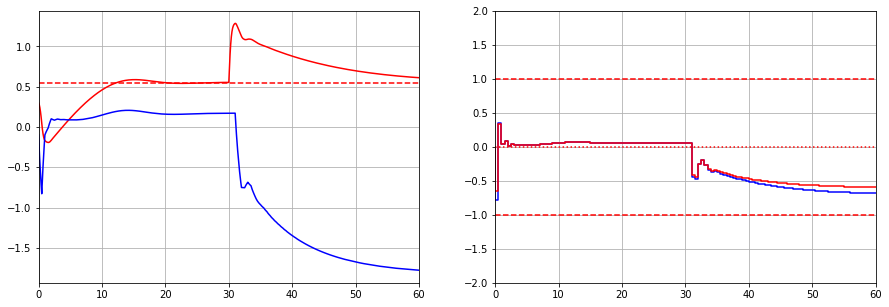

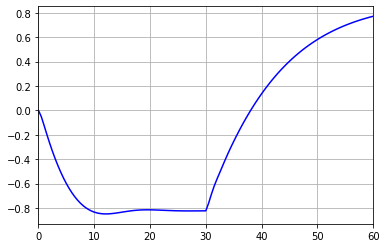

In [ ]:

reg = AKAR_i(goal=goal, gain=gain, dt=step, T1=0.5, T2=5.0, T3=0.5, v0=1.0)
res = calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure()
plt.plot(reg.zt, reg.z, 'b-')
plt.xlim([0.0, tk])
plt.grid()
plt.show()